In [1]:
import os
import json
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations

from gensim.utils import simple_preprocess
from gensim.models import LdaModel

from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from nltk.corpus import stopwords
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def read_data(data_dir, start=1992, end=2018):
    articles = []
    
    for year in range(start, (end+1)):
        with open(os.path.join(data_dir, str(year) + '.json')) as f:
            articles += json.load(f)

    df = pd.DataFrame(articles)
    return df

In [3]:
df = read_data('data/stt', start=2007, end=2008)

In [4]:
df.head()

,date,subjects,title,body
0,2007-06-25T12:01:01,[Tiedotepalvelu],*** Tiedote/Finnair Oyj: Finnairin ensilento M...,\n ****STT-TIEDOTEPALVELU****\n\nFinnairin en...
1,2007-06-06T14:32:07,[Julkishallinnon tiedotepalvelu],*** Tiedote/Suomen Kuntaliitto: Kuntaliiton va...,\n ****STT-TIEDOTEPALVELU****\n\nJulkivapaa: ...
2,2007-05-09T17:46:51,[Politiikka],Vanhanen: EU puhui patsaskiistassa yhdellä suu...,\n Pääministeri Matti Vanhasen mielestä Viron...
3,2007-02-20T10:46:04,[None],Kala on superterveellistä,\n – Kala on hyvä proteiinin lähde. Sadassa g...
4,2007-11-21T11:39:09,[Kulttuuri],Led Zeppelin esittää Lontoossa uuden kappaleen,\n Led Zeppelin esittää joulukuun reunion-kei...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251056 entries, 0 to 251055
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      251056 non-null  object
 1   subjects  251056 non-null  object
 2   title     246961 non-null  object
 3   body      251056 non-null  object
dtypes: object(4)
memory usage: 7.7+ MB


In [6]:
df['date'] = pd.to_datetime(df['date']) # .dt.date

In [7]:
df.sort_values('date', inplace=True)

In [8]:
df.head()

,date,subjects,title,body
99695,2006-02-16 23:15:07,[Urheilu],Eto'o jälleen Afrikan paras jalkapalloilija,\n Kamerunilainen kärkipelaaja Samuel Eto'o o...
23091,2007-01-01 00:04:40,[Talous],Valko-Venäjä ja Gazprom sopivat kaasukiistansa,\n Valko-Venäjä ja venäläinen kaasujätti Gazp...
26047,2007-01-01 01:00:02,[Talous],Sloveniasta tuli kolmastoista euromaa,\n Slovenia on liittynyt euron käyttäjiin. Si...
24418,2007-01-01 01:21:26,[Kotimaa],Omakotitalo paloi Mäntsälässä,\n Hirsinen omakotitalo paloi Mäntsälässä myö...
29404,2007-01-01 02:15:08,[Ulkomaat],Chirac yhä vaitonainen jatkosuunnitelmistaan,\n Ranskan presidentti Jacques Chirac pitää e...


In [9]:
df.drop(99695, axis=0, inplace=True)

In [10]:
df = df[df['date'] < '2008-12-01']

In [11]:
df.tail()

,date,subjects,title,body
132073,2008-11-30 23:32:20,[Urheilu],Jalkapallotuloksia/Italia,"\n Italian Serie A: Palermo–Milan 3–1, Udines..."
205827,2008-11-30 23:33:40,[Peliuutiset],*** Veikkaus/Tulosveto ***,\n ****STT-TIEDOTEPALVELU**** Tulosveto 48/08...
248977,2008-11-30 23:34:42,[Ulkomaat],Avaruussukkula laskeutui Kaliforniaan,\n Avaruussukkula Endeavour laskeutui Kalifor...
234362,2008-11-30 23:49:50,[Urheilu],Alppihiihtotuloksia/mc,"\n Aspen, Colorado: Alppihiihdon maailmancup,..."
193070,2008-11-30 23:52:10,[Urheilu],Painituloksia/Kv. turnaus,\n Haaparanta: Kv. painin Haaparanta cup. Nai...


In [12]:
df['subjects'] = df['subjects'].apply(lambda x: x[0] if len(x) else "None")

In [13]:
df['title'].fillna('', inplace=True)

In [14]:
df['body'] = df['title'] + ' ' + df['body']

In [16]:
stops_fi = set(stopwords.words('finnish'))
stops_fi2 = open("data/stopwords_fi_nlf.txt", "r").readlines()
stops_fi2 = [w.split()[1] for w in stops_fi2]
stops_fi.update(stops_fi2)

In [17]:
stops_fi = list(stops_fi)

In [19]:
def preprocessing(df, stopwords):
    # clean text and title and create new column "tokenized"
    tokens = df['body'].apply(simple_preprocess, max_len=30)
    # remove stopwords
    tokens = tokens.apply(lambda x: [w for w in x if w not in stopwords])
    return tokens

In [20]:
%%time
tokenized = preprocessing(df, stops_fi)

CPU times: user 7min 12s, sys: 1.27 s, total: 7min 13s
Wall time: 7min 14s


In [21]:
doc_lengths = tokenized.apply(lambda x: len(x))

In [24]:
print("length of list:",len(doc_lengths),
      "\naverage document length", doc_lengths.mean(),
      "\nminimum document length", doc_lengths.min(),
      "\nmaximum document length", doc_lengths.max(),
      "\nnumber document less than {} words:".format(10), (doc_lengths < 10).sum(),
      "\nnumber document more than {} words:".format(2000), (doc_lengths > 2000).sum())

length of list: 241726 
average document length 133.12888146082756 
minimum document length 0 
maximum document length 6690 
number document less than 10 words: 1353 
number document more than 2000 words: 1853


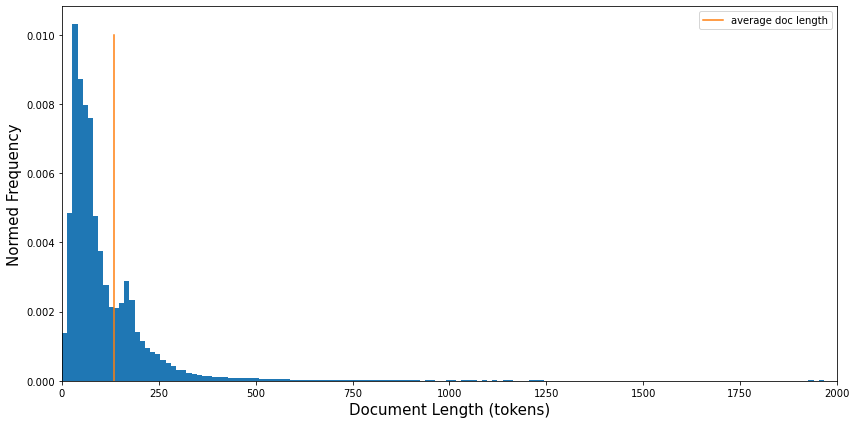

In [23]:
# plot a histogram of document length
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, bins=500, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()

plt.xlim(0, 2000)
# plt.ylim(0, 1)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0, 0.01, 10)], np.linspace(0.0, 0.01, 10), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [25]:
df['doc_len'] = doc_lengths
df['tokens'] = tokenized

In [26]:
# filter out documents < 20 or > 1000 tokens
df = df[(df['doc_len'] > 10) & (df['doc_len'] < 2000)]

In [27]:
df.shape

(237409, 6)

In [28]:
df.reset_index(drop=True, inplace=True)

In [29]:
df.head()

,date,subjects,title,body,doc_len,tokens
0,2007-01-01 00:04:40,Talous,Valko-Venäjä ja Gazprom sopivat kaasukiistansa,Valko-Venäjä ja Gazprom sopivat kaasukiistansa...,84,"[valko, venäjä, gazprom, sopivat, kaasukiistan..."
1,2007-01-01 01:00:02,Talous,Sloveniasta tuli kolmastoista euromaa,Sloveniasta tuli kolmastoista euromaa \n Slov...,39,"[sloveniasta, tuli, kolmastoista, euromaa, slo..."
2,2007-01-01 01:21:26,Kotimaa,Omakotitalo paloi Mäntsälässä,Omakotitalo paloi Mäntsälässä \n Hirsinen oma...,28,"[omakotitalo, paloi, mäntsälässä, hirsinen, om..."
3,2007-01-01 02:15:08,Ulkomaat,Chirac yhä vaitonainen jatkosuunnitelmistaan,Chirac yhä vaitonainen jatkosuunnitelmistaan ...,67,"[chirac, vaitonainen, jatkosuunnitelmistaan, r..."
4,2007-01-01 02:17:19,Ulkomaat,Itävallan sisäministeri kuoli yllättäen,Itävallan sisäministeri kuoli yllättäen \n It...,43,"[itävallan, sisäministeri, kuoli, yllättäen, i..."


In [30]:
df.drop('title', inplace=True, axis=1)

In [45]:
df['subjects'].unique()

array(['Talous', 'Kotimaa', 'Ulkomaat', 'Politiikka', 'Urheilu', 'Other',
       'Toimituksille tiedoksi', 'Sähkeuutiset', 'Päivälista',
       'Peliuutiset', 'Kulttuuri', 'Julkishallinnon tiedotepalvelu',
       'Tiedotepalvelu', 'Merkkipäiväpalvelu', 'Business wire'],
      dtype=object)

In [44]:
df['subjects'].fillna('Other', inplace=True)

In [32]:
df.to_pickle('data/stt/stt_token_cleaned.pkl')

In [33]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tokens'])]

In [34]:
model = Doc2Vec(vector_size=100, min_count=2, workers=4, dbow_words=1, negative=5)

In [35]:
%%time
model.build_vocab(documents)

CPU times: user 2min 37s, sys: 1.64 s, total: 2min 38s
Wall time: 2min 39s


In [36]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=20)

CPU times: user 42min 56s, sys: 1min 34s, total: 44min 31s
Wall time: 17min 18s


In [37]:
model.save('models/doc2vec/doc2vec_stt')

In [38]:
def infer_d2v(docs, model):
    vecs = np.zeros((len(docs), model.vector_size))
    for i, doc in enumerate(docs):
        vecs[i] = model.infer_vector(doc)
        
    return vecs

In [39]:
vecs = infer_d2v(df['tokens'], model)

In [40]:
pickle.dump(vecs, open('models/stt/stt_vecs.pkl', 'wb'))

In [ ]:
def group_by_time(df):
    # groups = df.groupby(df['date'].dt.date // 7)
    
    groups = df.groupby(pd.Grouper(key='date', freq='W'))
    df['group_id'] = groups.ngroup()
#     for name, g in groups:
#         print(name)

    return df

In [107]:
df = group_by_time(df)

229882

In [146]:
# train stt kmean
kmean = KMeans(n_clusters=20, random_state=2).fit(vecs)

In [170]:
def get_kmean_change(labels, df, n_cluster=20):
    changes = []    
    clusters = [list() for i in range(n_cluster)]
    
    # extract cluster ids
    for i, c in enumerate(labels):
        clusters[c].append(i)
    
    for c, ids in enumerate(clusters):
        # merge article index
        cluster = df.iloc[ids]
        
        # some group not exist in cluster, so we need to create array 100 as a frame
        # to avoid the missing group id in cluster
        freqs = pd.Series(np.zeros(100, dtype=int))
        counts = cluster.groupby('group_id').size()
        freqs.iloc[counts.index] = counts.values

        # counts = cluster.groupby(pd.Grouper(key='date', freq='7D')).size()
        # counts = cluster['date'].value_counts().sort_index()
        maj_class = cluster['subjects'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append((c, maj_class, freqs))
        
    return changes, clusters

In [171]:
km_change, km_clusters = get_kmean_change(kmean.labels_, df)

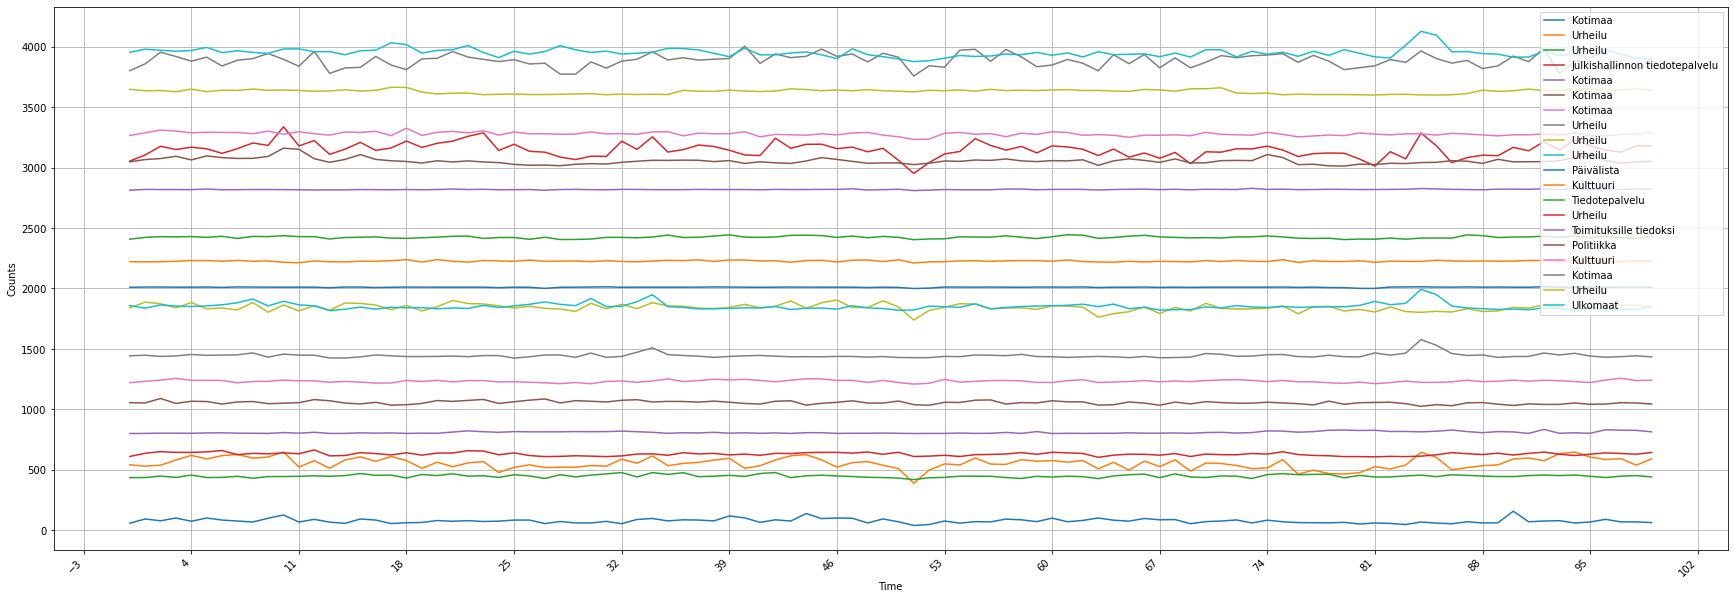

In [173]:
visualize_change(km_change)

In [174]:
pickle.dump(km_change, open('models/stt/stt_km_changes.pkl', 'wb'))

In [175]:
pickle.dump(kmean, open('models/stt/stt_kmeans.pkl', 'wb'))

In [80]:
df.tail(20)

,date,subjects,body,doc_len,tokens,group_id
237389,2008-11-30 22:14:10,Urheilu,"Alppihiihtotuloksia/m-cup \n Lake Louise, Kan...",39,"[alppihiihtotuloksia, cup, lake, louise, kanad...",99
237390,2008-11-30 22:29:40,Peliuutiset,*** Veikkaus/Voittajaveto *** \n ****STT-TIED...,92,"[veikkaus, voittajaveto, stt, tiedotepalvelu, ...",99
237391,2008-11-30 22:31:10,Urheilu,Helminen savusukelsi kolmanneksi \n Vielä eri...,52,"[helminen, savusukelsi, kolmanneksi, erinäisiä...",99
237392,2008-11-30 22:41:00,Urheilu,"Alppihiihtotuloksia/m-cup \n Lake Louise, Kan...",79,"[alppihiihtotuloksia, cup, lake, louise, kanad...",99
237393,2008-11-30 22:42:51,Other,Anniina vei Big Brother -potin \n Syksyn ajan...,90,"[anniina, vei, big, brother, potin, syksyn, aj...",99
237394,2008-11-30 22:42:54,Peliuutiset,*** Veikkaus/Tulosveto *** \n ****STT-TIEDOTE...,48,"[veikkaus, tulosveto, stt, tiedotepalvelu, tul...",99
237395,2008-11-30 22:48:01,Urheilu,Aalto Petanque-liiton johtoon \n Espoolainen ...,23,"[aalto, petanque, liiton, johtoon, espoolainen...",99
237396,2008-11-30 22:58:50,Urheilu,\n Tanja Poutiainen on sijoittunut kolmannek...,18,"[tanja, poutiainen, sijoittunut, kolmanneksi, ...",99
237397,2008-11-30 22:59:31,Urheilu,Poutiaisen hyvä laskuvire jatkuu - Aspenissa k...,37,"[poutiaisen, hyvä, laskuvire, jatkuu, aspeniss...",99
237398,2008-11-30 23:02:41,Sähkeuutiset,STT:n sähkeuutiset 30.11. klo 23.00 \n \n Tha...,184,"[stt, sähkeuutiset, thaimaassa, paluulentoa, o...",99


In [176]:
article_list = get_cluster_articles(km_clusters, df)

In [177]:
for i, a in enumerate(article_list):
    a = a.drop('tokens', axis=1)
    a.to_csv('models/stt/km/stt_km_cluster_'+str(i)+'.csv', index=False)

In [178]:
df.head()

,date,subjects,body,doc_len,tokens,group_id
0,2007-01-01 00:04:40,Talous,Valko-Venäjä ja Gazprom sopivat kaasukiistansa...,84,"[valko, venäjä, gazprom, sopivat, kaasukiistan...",0
1,2007-01-01 01:00:02,Talous,Sloveniasta tuli kolmastoista euromaa \n Slov...,39,"[sloveniasta, tuli, kolmastoista, euromaa, slo...",0
2,2007-01-01 01:21:26,Kotimaa,Omakotitalo paloi Mäntsälässä \n Hirsinen oma...,28,"[omakotitalo, paloi, mäntsälässä, hirsinen, om...",0
3,2007-01-01 02:15:08,Ulkomaat,Chirac yhä vaitonainen jatkosuunnitelmistaan ...,67,"[chirac, vaitonainen, jatkosuunnitelmistaan, r...",0
4,2007-01-01 02:17:19,Ulkomaat,Itävallan sisäministeri kuoli yllättäen \n It...,43,"[itävallan, sisäministeri, kuoli, yllättäen, i...",0


In [179]:
def get_articles_cluster(df, clusters, cluster_id, time_range=(0, 100)):
    ids = clusters[cluster_id]
    articles = df.iloc[ids]
    filtered = articles[(articles['group_id'] >= time_range[0]) & (articles['group_id'] <= time_range[1])]
    filtered = filtered.drop('tokens', axis=1)
    
    return filtered

In [221]:
check = get_articles_cluster(df, km_clusters, 4, (71, 95))

In [222]:
check.head()

,date,subjects,body,doc_len,group_id
170010,2008-05-12 12:49:50,Toimituksille tiedoksi,*** Tiedote/Valtioneuvoston viestintäyksikkö: ...,958,71
170153,2008-05-12 20:01:43,Julkishallinnon tiedotepalvelu,*** Tiedote/Valtioneuvoston viestintäyksikkö: ...,958,71
170774,2008-05-14 13:58:33,Toimituksille tiedoksi,*** Tiedote/Valtioneuvoston viestintäyksikkö: ...,780,71
170830,2008-05-14 16:01:43,Julkishallinnon tiedotepalvelu,*** Tiedote/Valtioneuvoston viestintäyksikkö: ...,780,71
171035,2008-05-15 08:37:15,Tiedotepalvelu,*** Tiedote/Helsingin yliopisto: HY: Väitökset...,1008,71


In [223]:
check['subjects'].value_counts()

Kotimaa                           125
Ulkomaat                           92
Other                              92
Julkishallinnon tiedotepalvelu     34
Tiedotepalvelu                     27
Toimituksille tiedoksi             17
Urheilu                             3
Kulttuuri                           1
Politiikka                          1
Name: subjects, dtype: int64

In [224]:
check.to_csv('data/stt/stt_km_4_2.csv')

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237409 entries, 0 to 237408
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      237409 non-null  datetime64[ns]
 1   subjects  237409 non-null  object        
 2   body      237409 non-null  object        
 3   doc_len   237409 non-null  int64         
 4   tokens    237409 non-null  object        
 5   group_id  237409 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 10.9+ MB


In [145]:
df.to_pickle('data/stt/stt_tokens_cleaned.pkl')

In [28]:
# Do topic modeling
def load_model(name='lda_stt_2007_2008'):
    model = LdaModel.load('models/lda/' + name)
    dct = Dictionary.load('models/lda/'+ name + '.id2word')
    return model, dct

In [29]:
lda, dct = load_model()

In [30]:
stops_fi = set(stopwords.words('finnish'))
stops_fi2 = open("data/stopwords_fi_nlf.txt", "r").readlines()
stops_fi2 = [w.split()[1] for w in stops_fi2]
stops_fi.update(stops_fi2)
stops_fi = list(stops_fi)

In [31]:
def remove_stopwords(tokens, stopwords):
    # remove stopwords
    cleaned = [w for w in tokens if not w in stopwords]
    return cleaned

In [32]:
cleaned_docs = df['tokens'].apply(remove_stopwords, args=(stops_fi,))

In [ ]:
# cleaned_docs[0]

In [33]:
corpus = [dct.doc2bow(doc) for doc in cleaned_docs]

In [97]:

def get_clusters(lda, corpus, min_prob=0.1):
    clusters = [list() for i in range(20)]
    
    for i, doc in enumerate(corpus):
        topics = lda.get_document_topics(doc, minimum_probability=min_prob)
        
        # incase not belong to any topic > threshold
        if len(topics) == 0:
            topics = lda.get_document_topics(doc)
            topics = [topics[0]]

        topics = [t[0] for t in topics]
        
        for topic in topics:
            clusters[topic].append(i)
            
    return clusters

def get_topic_term(lda, dictionary, n=20):
    topics = []
    
    for i in range(20):
        terms = lda.get_topic_terms(i, topn=n)
        words = []
        for t in terms:
            words.append(dictionary[t[0]])
        topics.append(words)
        
    return topics

def get_cluster_change(clusters, df):
    changes = []
    
    for i, ids in enumerate(clusters):
        # merge article index
        cluster = df.iloc[ids]
        counts = cluster.groupby(pd.Grouper(key='date', freq='7D')).size()
        # counts = cluster['date'].value_counts().sort_index()
        maj_class = cluster['subjects'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append((i, maj_class, counts))
        
    return changes
    



In [44]:
clusters = get_clusters(lda, corpus, min_prob=0.15)

In [45]:
df['date'].min(), df['date'].max()

(Timestamp('2007-01-01 00:04:40'), Timestamp('2008-11-30 23:49:50'))

In [54]:
changes = get_cluster_change(clusters, df)

In [61]:
changes[0]

(0,
 'Talous',
 date
 2007-01-01    250
 2007-01-08    261
 2007-01-15    325
 2007-01-22    323
 2007-01-29    368
              ... 
 2008-10-27    345
 2008-11-03    307
 2008-11-10    313
 2008-11-17    304
 2008-11-24    292
 Freq: 7D, Length: 100, dtype: int64)

In [52]:
def visualize_change(changes):    
    fig, ax = plt.subplots(figsize=(30, 10))
    # index = np.arange(100)
    distance = 0
    
    # cluster, maj_cats, counts = zip(*changes)
    # counts = np.array(counts) + 1
    # print(counts.shape)
    # counts = counts / counts[:, 0][:,None]
    # print(counts[-1])
    
    
    for cluster, cat, counts in changes:
        # val = counts[i] + distance
        # index = counts.index
        val = counts.values + distance
        ax.plot(counts.index, val, label=cat)
        distance += 200
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.set(xlabel='Time', ylabel='Counts')
    
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
    ax.legend()
    ax.grid()

    plt.show()


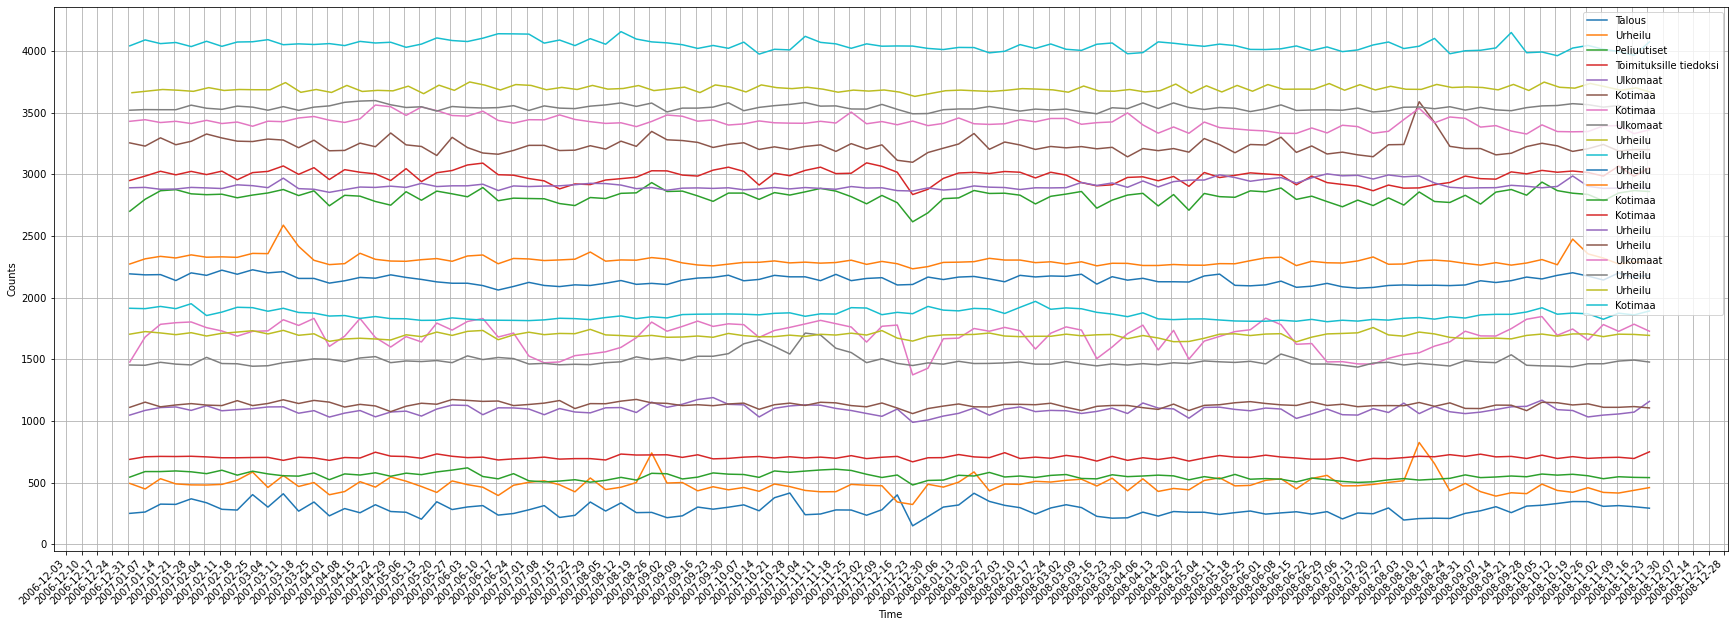

In [94]:
visualize_change(changes)

In [57]:
def get_cluster_articles(clusters, df):
    article_list = []
    for cluster in clusters:
        articles = df.iloc[cluster]
        article_list.append(articles)
        
    return article_list

In [69]:
article_list = get_cluster_articles(clusters, df)

In [71]:
article_list[3].head()

,date,subjects,body,doc_len,tokens
20,2007-01-01 06:00:10,None,Artikkelit viikko 1 \n \n ARTIKKELIT VIIKKO 1...,198,"[artikkelit, viikko, artikkelit, viikko, alla,..."
21,2007-01-01 06:00:10,Toimituksille tiedoksi,Artikkelit viikko 1 \n \n ARTIKKELIT VIIKKO 1...,198,"[artikkelit, viikko, artikkelit, viikko, alla,..."
57,2007-01-01 10:13:22,Toimituksille tiedoksi,Toimituksille tiedoksi \n \n Uudenvuodenpäivä...,150,"[toimituksille, tiedoksi, kotimaa, uudenvuoden..."
91,2007-01-01 15:05:23,Toimituksille tiedoksi,Ulkomaantoimituksille \n Iltaversio luvassa T...,92,"[iltaversio, luvassa, thaimaan, pommi, iskujen..."
101,2007-01-01 16:06:25,Toimituksille tiedoksi,Ulkomaantoimituksille -2 \n Indonesiassa kado...,39,"[indonesiassa, kadonneen, kohtalo, seurannassa..."


In [75]:
for i, a in enumerate(article_list):
    a = a.drop('tokens', axis=1)
    a.to_csv('models/stt_cluster_'+str(i)+'.csv', index=False)

In [73]:
pickle.dump(changes, open('models/stt_changes.pkl', 'wb'))

In [74]:
pickle.dump(clusters, open('models/stt_clusters.pkl', 'wb'))

In [98]:
terms = get_topic_term(lda, dct, n=30)

In [102]:
len(terms)

20

In [103]:
terms = pd.DataFrame(terms, columns=list(range(30)))
terms = terms.transpose()

In [104]:
terms.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,prosenttia,voitti,tiedote,mennessä,kertoi,helsingin,suomen,neuvottelut,antti,kosovon,kilpailu,keskustan,vain,suomen,kerroin,suomi,presidentti,kaudella,that,poliisi
1,euroa,kauden,tiedotepalvelu,ruotsin,keskiviikkona,mies,puheenjohtaja,tänään,jukka,metriä,miesten,puolueen,sanoo,vuonna,lähtö,venäjä,venäjän,liigan,finnish,ihmistä
2,vuonna,pistettä,http,merkkiä,torstaina,käräjäoikeus,hallituksen,sopimuksen,mikko,peliaika,ottelun,helsinki,hyvin,vuoden,toto,saksa,yhdysvaltain,joukkueen,finland,poliisin
3,miljoonaa,sarjan,liitteet,kuva,tiistaina,miehen,hallitus,alan,pekka,serbian,naisten,naiset,pitää,helsingin,poissa,ruotsi,pääministeri,valmentaja,said,mies
4,vuoden,suomen,lisätietoja,juttu,perjantaina,oikeus,uuden,putin,ville,jääkiekko,päivän,kokoomuksen,olevan,vuotta,oikea,ranska,venäjä,pelannut,minister,kuoli


In [105]:
terms.to_csv('models/stt_terms.csv', index=False)